In [1]:
install.packages(c('Boruta','caret'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ranger’




In [2]:
library(caret)
library(Boruta)

Loading required package: ggplot2

Loading required package: lattice



In [3]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Boruta_7.0.0    caret_6.0-90    lattice_0.20-41 ggplot2_3.3.3  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-4         tidyselect_1.1.0     repr_1.1.0          
 [4] purrr_0.3.4          reshape2_1.4.4       splines_4.0.3       
 [7] colorspace_2.0-

In [4]:
# Error function
calc_RMSE <- function(act,pred){
  
  aact <- as.matrix(act)
  ppred <- as.matrix(pred)
  
  if(nrow(aact) == nrow(ppred)){ 
    return (sqrt(sum(((ppred) - (aact)) ^ 2) / nrow(aact)))
  } else {
    return (-99)
  }
}

calc_avg_abs_error <- function(act,pred){
  
  aact <- as.matrix(act)
  ppred <- as.matrix(pred)
  
  if(nrow(aact) == nrow(ppred)){ 
    return (sum(abs(ppred - aact)) / nrow(aact))
  } else {
    return (-99)
  }
}

calc_r2<-function(act,pred){
  rss <- sum((pred - act)^2)       #residual sum of squares
  tss <- sum((act - mean(act))^2)  #total sum of squares
  rsq <- 1 - rss/tss
  return (rsq)
}

Plot_RMSE<-function(Train,Pred,approach){
  plot(Pred, testing$Yield, col=alpha("blue",0.5),
       xlab="prediction", ylab="original data", 
       xlim=c(0,100), ylim=c(0,100),pch=20,cex=2.0) #original
  points(Train, training$Yield, col=alpha("red",0.5),pch=20,cex=2.0) #Training
  abline(0,1,col='black',lwd=2,lty=1)
  title(main=paste(approach,"Actual/Prediction Parity Plot",sep=" "))
  text(30,80, sprintf("Testing Set R^2 = %.2f", calc_r2(testing$Yield, Pred)), col='black', cex=1)
  text(30,85, sprintf("Testing Set RMSE = %.2f", calc_RMSE(testing$Yield, Pred)), col='black', cex=1)
  legend("bottomright", legend=c("Training set","Testing set"), cex=1.1, 
         pch=20,col=c("red","blue"))
}

In [6]:
d1 <- read.csv("data/data_EtOH_Final.csv", header=TRUE)
unique(d1$Electrophile)

[1] "1H-indol-5-yl N,N-dimethylsulfamate"                   
 [2] "2-bromo-1,1'-biphenyl"                                 
 [3] "2-Chloro-5-fluorotoluene"                              
 [4] "2-Chloro-m-xylene"                                     
 [5] "(2-Methyl-1,3-benzothiazol-5-yl) N,N-dimethylsulfamate"
 [6] "3-Bromothiophene"                                      
 [7] "3-Chloro-2-methylaniline"                              
 [8] "4-Bromoanisole"                                        
 [9] "4-Bromobenzotrifluoride"                               
[10] "4-Chloro-N,N-dimethylbenzamide"                        
[11] "5-chloroindole"                                        
[12] "BMS-929356"                                            
[13] "Ethyl 4-chloro-3-fluorobenzoate"                       
[14] "methyl 4-bromobenzoate"                                
[15] "quinolin-6-yl dimethylsulfamate"                       
[16] "3-Bromoquinoline"                                      
[17] "3-bromo-2-methylpyridine"                              
[18] "Clofibrate"                                            
[19] "4-Bromo-2-fluoroanisole"                               
[20] "4-Bromo-2-fluorobenzonitrile"                          
[21] "(4-Phenylphenyl) N,N-dimethylsulfamate"                
[22] "4-Bromo-1,2-(methylenedioxy)benzene"                   
[23] "5-Bromobenzofuran"                                     
[24] "4-chloro-1-fluoro-2-methoxybenzene"                    
[25] "4-chlorobenzotrifluoride"                              
[26] "3-chloroquinoline"                                     
[27] "5-bromo-2,4-dimethoxypyrimidine"                       
[28] "methyl 4-chlorobenzoate"                               
[29] "5-Chloro-1,3-benzodioxole"                             
[30] "4-chloro-2-fluoro-1-methoxybenzene"                    
[31] "4-Chloro-2-fluoroanisole"                              
[32] "4-Chlorobiphenyl"                                      
[33] "4-Bromobiphenyl"                                       
[34] "4-Chloro-2-fluorobenzonitrile"

In [7]:
#Hold-out set
unique(d1$Electrophile)[c(1,13,18)]

[1] "1H-indol-5-yl N,N-dimethylsulfamate" "Ethyl 4-chloro-3-fluorobenzoate"    
[3] "Clofibrate"

In [8]:
cols<-c("Electrophile","Electrophile_inchi","Ligand","Ligand_inchi","Product_inchi","Solvent_inchi")
ML_val=d1[d1$Electrophile %in% unique(d1$Electrophile)[c(1,13,18)],]
ML_val2<-ML_val[,!names(ML_val)%in%cols]
dim(ML_val2)

[1]  69 157

In [9]:
#Training set will be used for Boruta Feature Selection, then parse the selected predictors to RF in CARET
ML_train=d1[!d1$Electrophile %in% unique(d1$Electrophile)[c(1,13,18)],]
ML_train2<-ML_train[,!names(ML_train)%in%cols]
dim(ML_train2)

[1] 710 157

In [10]:
predictors <- names(ML_train2)[names(ML_train2) != c("Yield")]
#predictors

In [11]:
#############Scaling##############
descriptor.data <- scale(ML_train2[,predictors]) 
training <- as.data.frame(descriptor.data)
training$Yield<-ML_train2$Yield

In [12]:
set.seed(222)
Boruta.test2 <- Boruta(Yield ~ ., data = training, doTrace = 2, ntree = 500, maxRuns=500) 

 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

 14. run of importance source...

After 14 iterations, +20 secs: 

 confirmed 53 attributes: ArylHalide_C_Chem.Shift, ArylHalide_C_Electrostatic, ArylHalide_C_Exposed.Area, ArylHalide_C_Mulliken, ArylHalide_CX_Lowdin and 48 more;

 rejected 7 attributes: Kraken_dipolemoment_boltz, Kraken_qpole_amp_min, Kraken_qpoletens_yy_vburminconf, Kraken_spindens_P_ra_boltz, Kraken_sterimol_B5_boltz and 2 more;

 still have 96 attributes left.


 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

 18. run of importance sourc

 116. run of importance source...

After 116 iterations, +2.3 mins: 

 confirmed 1 attribute: Kraken_sterimol_burB1_min;

 still have 31 attributes left.


 117. run of importance source...

 118. run of importance source...

 119. run of importance source...

After 119 iterations, +2.4 mins: 

 confirmed 1 attribute: Kraken_qpole_amp_boltz;

 still have 30 attributes left.


 120. run of importance source...

 121. run of importance source...

 122. run of importance source...

 123. run of importance source...

 124. run of importance source...

 125. run of importance source...

 126. run of importance source...

 127. run of importance source...

 128. run of importance source...

 129. run of importance source...

 130. run of importance source...

 131. run of importance source...

 132. run of importance source...

 133. run of importance source...

 134. run of importance source...

 135. run of importance source...

 136. run of importance source...

After 136 iterations, +2.7

 316. run of importance source...

 317. run of importance source...

 318. run of importance source...

 319. run of importance source...

 320. run of importance source...

 321. run of importance source...

 322. run of importance source...

 323. run of importance source...

 324. run of importance source...

After 324 iterations, +6.1 mins: 

 rejected 1 attribute: Kraken_vbur_qvtot_max_delta;

 still have 21 attributes left.


 325. run of importance source...

 326. run of importance source...

 327. run of importance source...

 328. run of importance source...

 329. run of importance source...

 330. run of importance source...

 331. run of importance source...

 332. run of importance source...

 333. run of importance source...

 334. run of importance source...

 335. run of importance source...

 336. run of importance source...

 337. run of importance source...

 338. run of importance source...

 339. run of importance source...

 340. run of importance source...

 34

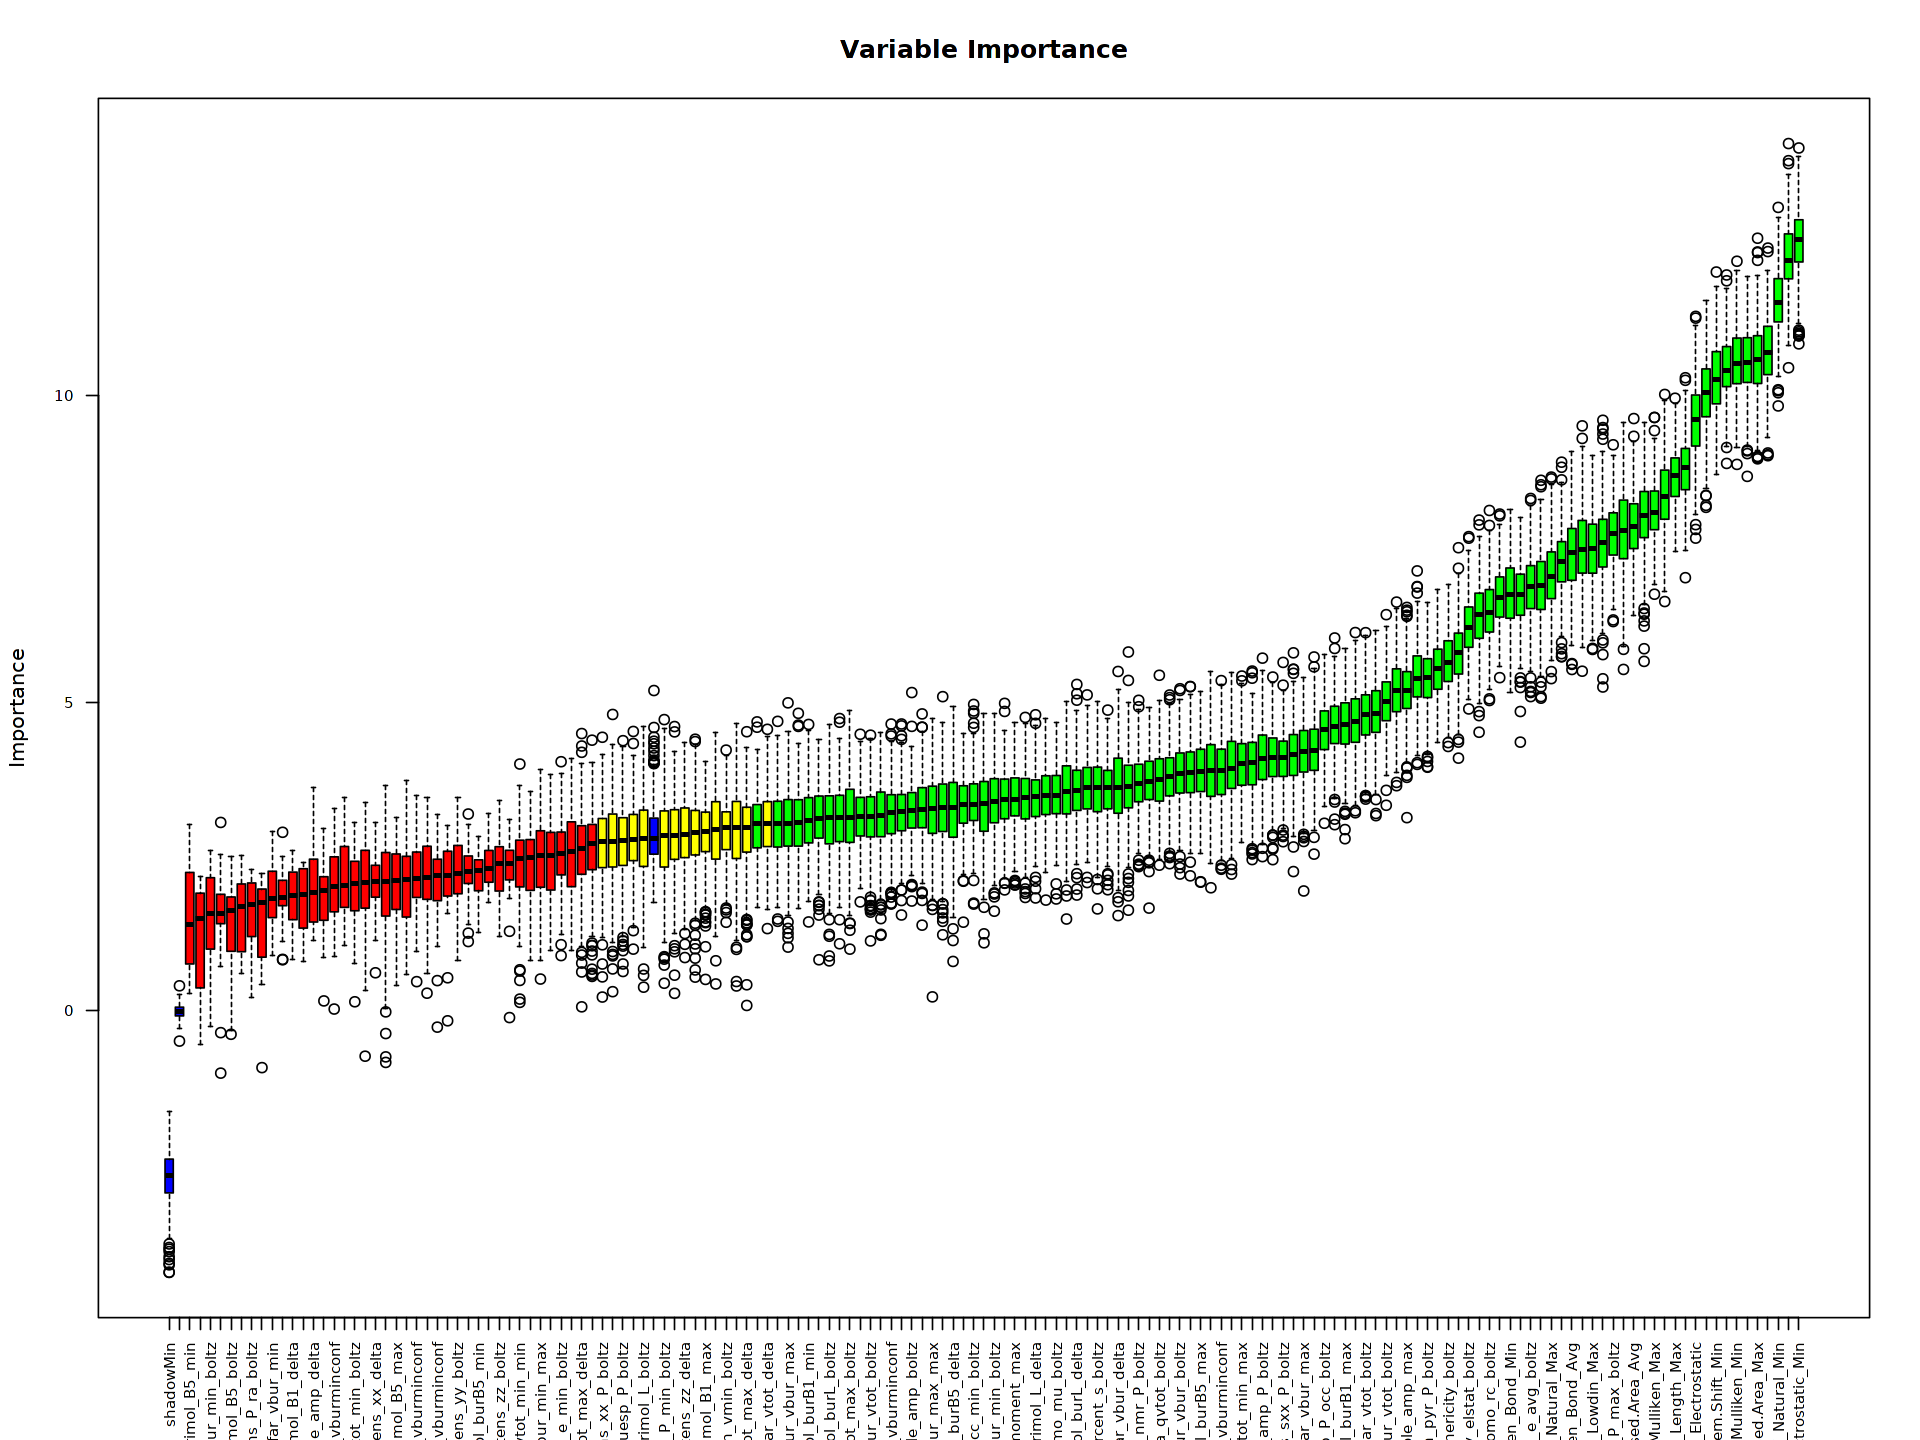

In [13]:
options(repr.plot.width=16, repr.plot.height=12)
plot(Boruta.test2,cex.axis=.7, las=2, xlab="", main="Variable Importance")

In [14]:
getSelectedAttributes(Boruta.test2)

[1] "ArylHalide_CX_Lowdin"                   
  [2] "ArylHalide_C_Chem.Shift"                
  [3] "ArylHalide_C_Electrostatic"             
  [4] "ArylHalide_C_Exposed.Area"              
  [5] "ArylHalide_C_Mulliken"                  
  [6] "ArylHalide_XY_Chem.Shift_Max"           
  [7] "ArylHalide_XY_Chem.Shift_Min"           
  [8] "ArylHalide_XY_Electrostatic_Max"        
  [9] "ArylHalide_XY_Electrostatic_Min"        
 [10] "ArylHalide_XY_Exposed.Area_Avg"         
 [11] "ArylHalide_XY_Exposed.Area_Max"         
 [12] "ArylHalide_XY_Exposed.Area_Min"         
 [13] "ArylHalide_XY_Length_Max"               
 [14] "ArylHalide_XY_Length_Min"               
 [15] "ArylHalide_XY_Lowdin_Avg"               
 [16] "ArylHalide_XY_Lowdin_Max"               
 [17] "ArylHalide_XY_Lowdin_Min"               
 [18] "ArylHalide_XY_Mulliken_Bond_Avg"        
 [19] "ArylHalide_XY_Mulliken_Bond_Max"        
 [20] "ArylHalide_XY_Mulliken_Bond_Min"        
 [21] "ArylHalide_XY_Mulliken_Max"             
 [22] "ArylHalide_XY_Mulliken_Min"             
 [23] "ArylHalide_XY_Natural_Max"              
 [24] "ArylHalide_XY_Natural_Min"              
 [25] "ArylHalide_X_Electrostatic"             
 [26] "ArylHalide_X_Mulliken"                  
 [27] "Kraken_E_solv_cds_boltz"                
 [28] "Kraken_E_solv_elstat_boltz"             
 [29] "Kraken_E_solv_total_boltz"              
 [30] "Kraken_Pint_P_max_boltz"                
 [31] "Kraken_Pint_dP_boltz"                   
 [32] "Kraken_dipolemoment_max"                
 [33] "Kraken_dipolemoment_vburminconf"        
 [34] "Kraken_efg_amp_P_boltz"                 
 [35] "Kraken_fmo_e_lumo_boltz"                
 [36] "Kraken_fmo_eta_boltz"                   
 [37] "Kraken_fmo_mu_boltz"                    
 [38] "Kraken_nbo_P_boltz"                     
 [39] "Kraken_nbo_P_ra_boltz"                  
 [40] "Kraken_nbo_P_rc_boltz"                  
 [41] "Kraken_nbo_bd_e_max_boltz"              
 [42] "Kraken_nbo_bd_occ_avg_boltz"            
 [43] "Kraken_nbo_bd_occ_min_boltz"            
 [44] "Kraken_nbo_bds_e_avg_boltz"             
 [45] "Kraken_nbo_bds_occ_avg_boltz"           
 [46] "Kraken_nbo_bds_occ_max_boltz"           
 [47] "Kraken_nbo_lp_P_occ_boltz"              
 [48] "Kraken_nbo_lp_P_percent_s_boltz"        
 [49] "Kraken_nmr_P_boltz"                     
 [50] "Kraken_nmrtens_sxx_P_boltz"             
 [51] "Kraken_nmrtens_szz_P_boltz"             
 [52] "Kraken_pyr_P_boltz"                     
 [53] "Kraken_pyr_P_delta"                     
 [54] "Kraken_pyr_P_max"                       
 [55] "Kraken_pyr_P_min"                       
 [56] "Kraken_pyr_P_vburminconf"               
 [57] "Kraken_qpole_amp_boltz"                 
 [58] "Kraken_qpole_amp_max"                   
 [59] "Kraken_somo_rc_boltz"                   
 [60] "Kraken_sphericity_boltz"                
 [61] "Kraken_sterimol_B1_vburminconf"         
 [62] "Kraken_sterimol_B5_delta"               
 [63] "Kraken_sterimol_L_delta"                
 [64] "Kraken_sterimol_L_max"                  
 [65] "Kraken_sterimol_L_min"                  
 [66] "Kraken_sterimol_L_vburminconf"          
 [67] "Kraken_sterimol_burB1_boltz"            
 [68] "Kraken_sterimol_burB1_max"              
 [69] "Kraken_sterimol_burB1_min"              
 [70] "Kraken_sterimol_burB5_delta"            
 [71] "Kraken_sterimol_burB5_max"              
 [72] "Kraken_sterimol_burB5_vburminconf"      
 [73] "Kraken_sterimol_burL_boltz"             
 [74] "Kraken_sterimol_burL_delta"             
 [75] "Kraken_sterimol_burL_max"               
 [76] "Kraken_sterimol_burL_min"               
 [77] "Kraken_sterimol_burL_vburminconf"       
 [78] "Kraken_vbur_max_delta_qvbur_min"        
 [79] "Kraken_vbur_max_delta_qvbur_vburminconf"
 [80] "Kraken_vbur_max_delta_qvtot_boltz"      
 [81] "Kraken_vbur_max_delta_qvtot_delta"      
 [82] "Kraken_vbur_max_delta_qvtot_min"        
 [83] "Kraken_vbur_max_delta_qvtot_vburminconf"
 [84] "Kraken_vbur

In [15]:
length(getSelectedAttributes(Boruta.test2))

[1] 101

In [16]:
#Parse Boruta features to the randomforest model
predictors <- getSelectedAttributes(Boruta.test2)
ctrl <- trainControl(method = "cv",  
                     number = 10, 
                     allowParallel = FALSE,
                     returnResamp = "all")

In [17]:
#Random Forest
set.seed(222)
system.time(Rf_Fit<- train(data.matrix(training[,predictors]), 
                             training$Yield,
                             method = 'rf',
                             metric = "RMSE",
                             importance = TRUE,
                             trControl = ctrl))

   user  system elapsed 
232.082   0.153 232.242 

rf variable importance

  only 20 most important variables shown (out of 101)

                                Overall
ArylHalide_XY_Electrostatic_Min   19.34
ArylHalide_XY_Lowdin_Min          19.19
Kraken_nbo_bds_e_avg_boltz        18.67
ArylHalide_X_Electrostatic        14.49
ArylHalide_C_Electrostatic        14.05
ArylHalide_XY_Exposed.Area_Max    13.80
ArylHalide_XY_Lowdin_Avg          13.05
ArylHalide_C_Mulliken             12.94
Kraken_Pint_P_max_boltz           12.86
ArylHalide_XY_Natural_Min         12.61
ArylHalide_XY_Mulliken_Min        12.46
ArylHalide_C_Chem.Shift           12.34
ArylHalide_XY_Exposed.Area_Min    11.59
ArylHalide_X_Mulliken             11.52
ArylHalide_XY_Chem.Shift_Min      10.87
ArylHalide_XY_Mulliken_Max        10.58
ArylHalide_XY_Chem.Shift_Max      10.31
ArylHalide_C_Exposed.Area         10.16
ArylHalide_XY_Electrostatic_Max   10.02
Kraken_vbur_qvbur_max_min         10.02

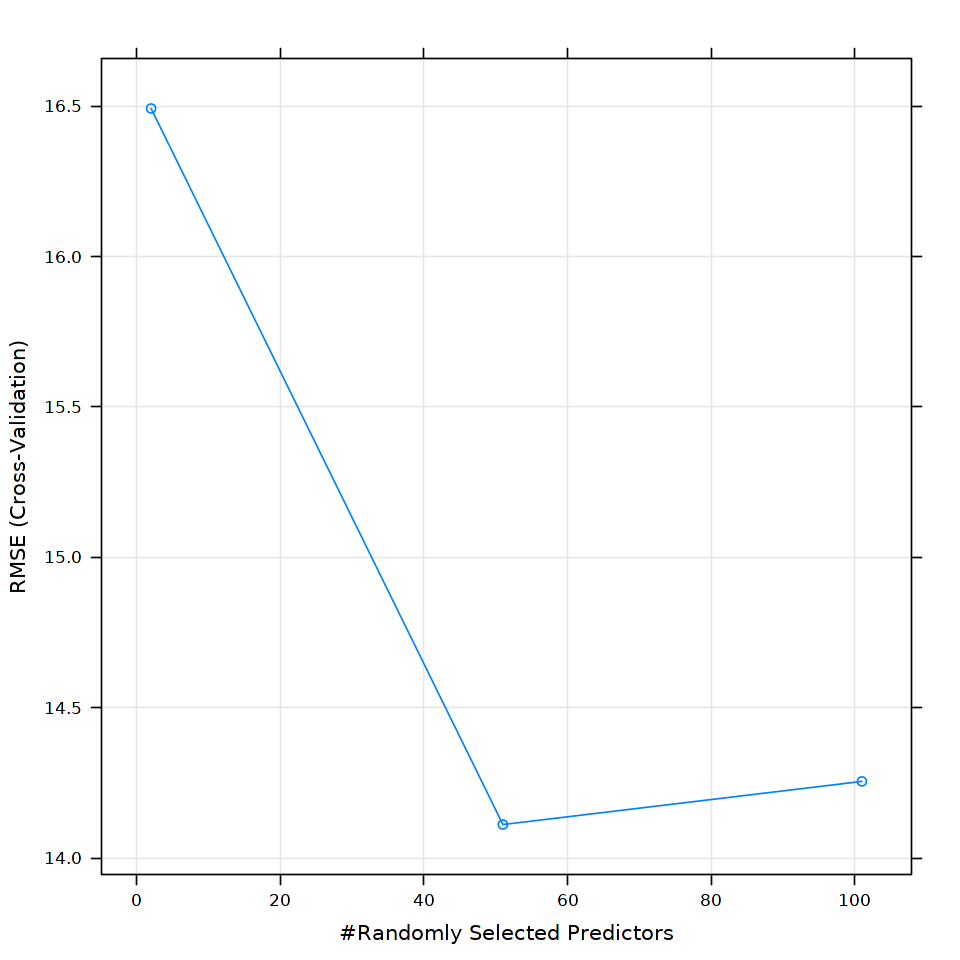

In [18]:
varImp(Rf_Fit, scale = FALSE)

options(repr.plot.width=8, repr.plot.height=8)
plot(Rf_Fit, metric="RMSE")

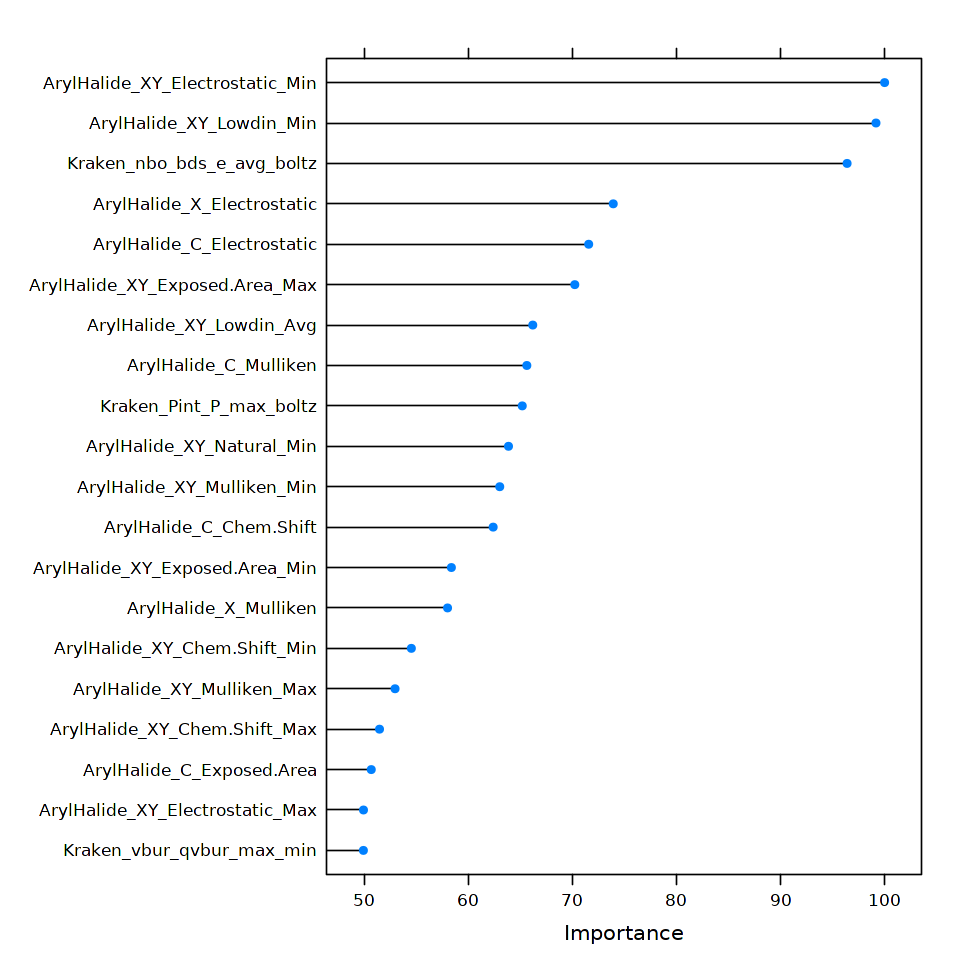

In [19]:
plot(varImp(Rf_Fit), top = 20)

In [20]:
# Scale the external validation set data using the same scaling as for the training.
predictors_before_Boruta<- names(ML_train2)[names(ML_train2) != c("Yield")]
ext.data2 <- scale(ML_val2[,predictors_before_Boruta],
                          attr(descriptor.data,"scaled:center"),
                          attr(descriptor.data,"scaled:scale"))
validation<- as.data.frame(ext.data2)
validation$Yield<-ML_val2$Yield

In [21]:
modelFit<-Rf_Fit
Train <- predict(modelFit, data.matrix(training[,predictors]))

#validation set
val_pred<-predict(modelFit, data.matrix(validation[,predictors]))

In [26]:
Plot_RMSE2<-function(Train,Pred,approach){
  plot(Pred, validation$Yield, col=alpha("darkblue",0.5),
       xlab="prediction", ylab="original data", 
       xlim=c(0,100), ylim=c(0,100),pch=20,cex=2.5) #original
  points(Train, training$Yield, col=alpha("red",0.5),pch=20,cex=2.5) #Training
  abline(0,1,col='black',lwd=2,lty=1)
  title(main=paste(approach,"Actual/Prediction Parity Plot",sep=" "))
  text(30,90, sprintf("Validation Rsquared = %.2f", calc_r2(validation$Yield, Pred)), col='black', cex=1)
  text(30,95, sprintf("Validation RMSE = %.2f", calc_RMSE(validation$Yield, Pred)), col='black', cex=1)
  legend("bottomright", legend=c("Training set","Validation"), cex=1.1, 
         pch=20,col=c("red","darkblue"))
}

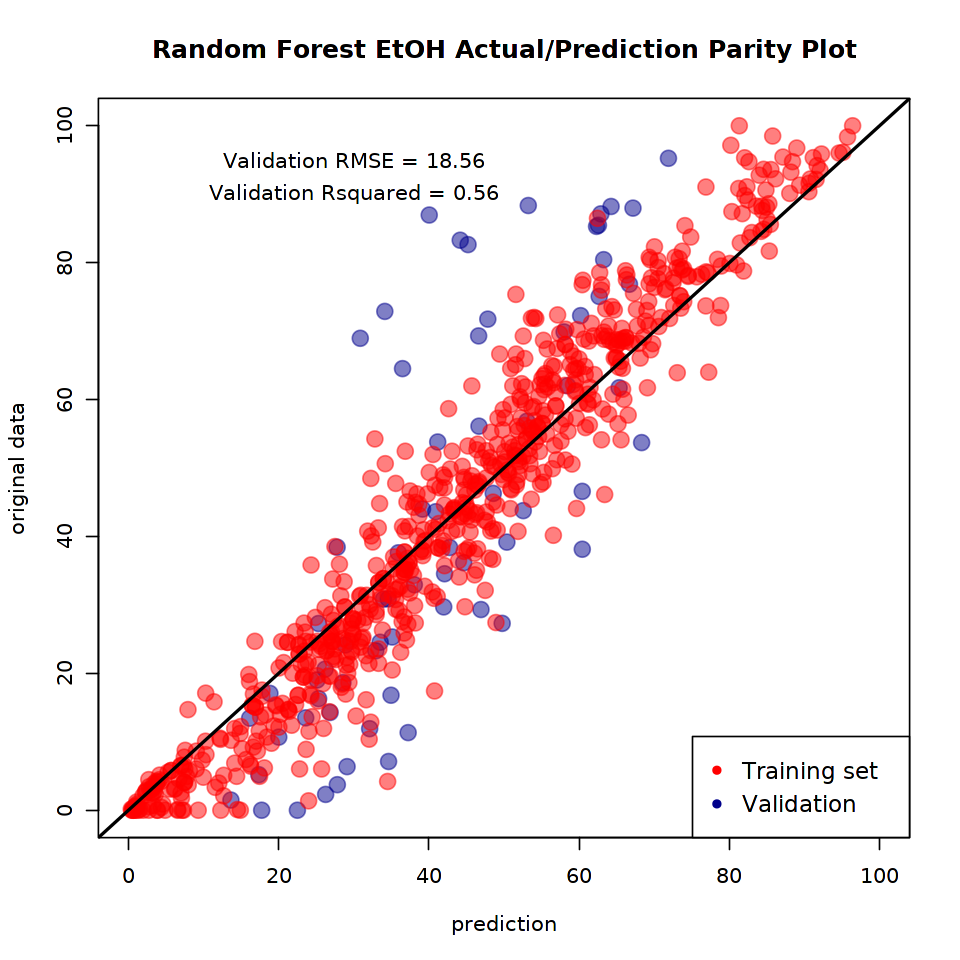

In [27]:
Plot_RMSE2(Train,val_pred,"Random Forest EtOH")

In [28]:
save.image()